In [1]:
from IPython.display import clear_output
!pip install datasets
!pip install arabic-reshaper python-bidi
clear_output()

In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datasets
from datasets import load_dataset
import transformers
from transformers import BertTokenizer, AutoModel,BertModel
from google.colab import drive
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from bidi.algorithm import get_display
import arabic_reshaper
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
random.seed(0)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
#data loading and preprocessing
class ExpoDataset_BERT(Dataset):
  def __init__(self,dataset_path,onehotencoder=None,tokenizer_name='UBC-NLP/MARBERT'):
    expodataset_features=datasets.Features({'Tweet':datasets.Value('string'),'Class':datasets.Value('string')})
    self.dataset=load_dataset("csv", data_files=dataset_path,features=expodataset_features,split='train')
    self.tokenizer=BertTokenizer.from_pretrained(tokenizer_name)
    self.onehotencoder=onehotencoder if onehotencoder else OneHotEncoder()
    self.onehotencoder.fit(np.reshape(self.dataset[:]['Class'],(-1,1)))
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,idx):
    item=self.tokenizer(str(self.dataset[idx]['Tweet']),add_special_tokens=True,max_length=44,padding='max_length',truncation=True,return_tensors='pt')

    item['label']=torch.tensor(self.onehotencoder.transform([[self.dataset[idx]['Class']]]).toarray())[0]
    item['input_ids']=item['input_ids'][0]
    item['attention_mask']=item['attention_mask'][0]
    return item

In [5]:
dataset=ExpoDataset_BERT('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_training_set.csv')
test_dataset=ExpoDataset_BERT('/content/drive/MyDrive/SeniorProject1/data/experiment/SP2_new_testing_set.csv',dataset.onehotencoder)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
seed = torch.Generator().manual_seed(42)
train_set,val_set=torch.utils.data.random_split(dataset,[0.85,0.15], generator=seed)
len(train_set),len(val_set)

(6375, 1125)

In [8]:
full_dataloader=DataLoader(dataset,pin_memory=True,num_workers=8,batch_size=64,shuffle=True)
train_loader=DataLoader(train_set,pin_memory=True,num_workers=8,batch_size=64,shuffle=True)
val_loader=DataLoader(val_set,pin_memory=True,num_workers=8,batch_size=64,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
#helper function to automate the loss and accuracy plots
def plot_loss_accuracy(train_total_loss,val_total_loss,train_accuracies,val_accuracies):
  plt.subplots(figsize=(12,4))
  plt.subplot(121)
  plt.plot(train_total_loss,label='train')
  if len(val_total_loss)!=0:
    plt.plot(val_total_loss,label='val')
  plt.title('Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(train_accuracies,label='train')
  if len(val_accuracies)!=0:
    plt.plot(val_accuracies,label='val')
  plt.title('Accuracies')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [11]:
def visualize(text_ids,weights,predictions,labels):

  positives_weights = weights[labels == 2]
  negatives_weights = weights[labels == 0]
  neutrals_weights = weights[labels == 1]

  positives_text_ids = text_ids[labels == 2]
  negatives_text_ids = text_ids[labels == 0]
  neutrals_text_ids = text_ids[labels == 1]

  # Randomly selecting indices for each class
  positive_indices = np.random.choice(np.arange(len(positives_weights)), size=1)
  negative_indices = np.random.choice(np.arange(len(negatives_weights)), size=1)
  neutral_indices = np.random.choice(np.arange(len(neutrals_weights)), size=1)

  fig, axs = plt.subplots(3, figsize=(10, 6))
  #axs = [axs]  # Ensure axs is iterable if there's only one plot
  #print('axs=',type(axs[0]),axs[0])
  # Function to plot heatmaps for a given class
  def plot_heatmaps(indecies, text_ids_, weights_, ax_row):
      for index in indecies:
          text = dataset.tokenizer.decode(text_ids_[index]).split(' ')
          reshaped_text = [arabic_reshaper.reshape(token) for token in text]
          bidi_text = [get_display(token) for token in reshaped_text]
          correct_weight = weights_[index]

          # Create the heatmap for the current index
          heatmap = axs[ax_row].imshow([correct_weight], cmap='YlGnBu', aspect='auto')

          # Set the tokens as x-ticks
          axs[ax_row].set_xticks(np.arange(len(bidi_text)))
          axs[ax_row].set_xticklabels(bidi_text, rotation=90)

          # Remove y-ticks
          axs[ax_row].set_yticks([])
      plt.tight_layout()
      return heatmap

  # Plot heatmaps for positive, negative, and neutral predictions
  heatmap=plot_heatmaps(negative_indices, negatives_text_ids, negatives_weights, 0)  # Row 0 for negative
  heatmap=plot_heatmaps(neutral_indices, neutrals_text_ids, neutrals_weights, 1)  # Row 1 for neutral
  heatmap=plot_heatmaps(positive_indices, positives_text_ids, positives_weights, 2)     # Row 2 for positive

  # Set overall titles for each row
  axs[0].set_ylabel('Negative', rotation=0, labelpad=50, fontsize=12)
  axs[1].set_ylabel('Neutral', rotation=0, labelpad=50, fontsize=12)
  axs[2].set_ylabel('Positive', rotation=0, labelpad=50, fontsize=12)

  # Create a single color bar for the entire figure
  cbar_ax = fig.add_axes([1, 0.15, 0.01, 0.8])  # [left, bottom, width, height]
  plt.colorbar(heatmap, cax=cbar_ax)

  plt.suptitle('Attention Weights', fontsize=16, x=0.5, y=1.02)  # Adjust the y-position for the title
  #plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
  plt.show()

In [12]:
# Test on the test_loader
def test_and_report(model,test_loader,model_name,attention_added=False):
  model.eval()
  predictions=[]
  labels=[]
  test_total_dataitem=0
  test_correct=0
  input_ids_list=[]
  attention_weights=[]
  correct_answers=[]
  all_labels=[]
  with torch.no_grad():
      for batch in test_loader:
          input_ids,attention_mask,label=batch.input_ids.to(device),batch.attention_mask.to(device),batch.label.to(device)
          output=model(input_ids,attention_mask)
          if attention_added:
            attention_weights.extend(output[1].cpu().numpy())
            output=output[0]



          # Compute the accuracy
          y_pred=F.softmax(output,dim=1)
          predicted = y_pred.argmax(axis=1)
          test_total_dataitem += label.size(0)
          test_correct += (predicted == label.argmax(axis=1)).sum()
          predictions.extend(predicted.cpu().numpy())
          labels.extend(label.argmax(axis=1).cpu().numpy())

          input_ids_list.extend(input_ids.cpu().numpy())
          all_labels.extend(label.argmax(axis=1).cpu().numpy())
          correct_answers.extend((predicted == label.argmax(axis=1)).cpu().numpy())


  test_accuracy = test_correct/test_total_dataitem
  print(f'Test correct = {test_correct}\n')
  print(f'Test total dataitem = {test_total_dataitem}\n')
  print(f'Test Accuracy = {test_accuracy}\n')
  print(classification_report(labels,predictions,target_names=['negative','neutral','positive']))
  fig,ax=plt.subplots(figsize=(5, 5))
  ConfusionMatrixDisplay.from_predictions(labels,predictions,display_labels=['negative','neutral','positive'],normalize='pred',cmap=plt.cm.Blues, xticks_rotation='vertical',ax=ax)
  plt.title(f'Confusion Matrix of {model_name}')
  plt.show()
  if attention_added:
    visualize(np.array(input_ids_list),np.array(attention_weights),correct_answers,np.array(all_labels))

In [15]:
class AttentionLayer(nn.Module):
    def __init__(self, rnn_size):
        super(AttentionLayer, self).__init__()
        self.U = nn.Linear(rnn_size, 1,bias=False) # for the learnable paramter u
        torch.nn.init.xavier_normal_(self.U.weight)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden_states):
        # α = softmax(u_t^T U)
        attention_weights = self.U(hidden_states) # (batch_size, seq_len ,1)
        attention_weights = self.softmax(attention_weights.squeeze(2))  # (batch_size, seq_len)

        # eq.11: v = sum( α * hidden_states )
        attention_output = hidden_states * attention_weights.unsqueeze(2)  # (batch_size, seq_len, rnn_size)
        attention_output = attention_output.sum(dim = 1)  # (batch_size, rnn_size)

        return attention_output, attention_weights

In [19]:
class AttentionRNN_AraBERT(nn.Module):
  def __init__(self,hidden_size1,hidden_size2,num_layers,dider=True,droprate=0.2,num_classes=3,model_type='rnn'):
    super().__init__()
    self.bert=BertModel.from_pretrained('UBC-NLP/MARBERT')
    # freeze the bert weights
    for param in self.bert.parameters():
      param.requires_grad=False

    self.embedding_dim=self.bert.config.hidden_size
    self.rnn_hidden_size=hidden_size1
    if model_type=='gru':
      self.rnn=nn.GRU(self.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    elif model_type=='lstm':
      self.rnn=nn.LSTM(self.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    else:
      self.rnn=nn.RNN(self.embedding_dim,hidden_size1,num_layers,batch_first=True,bidirectional=dider)
    self.dropout=nn.Dropout(droprate)
    self.d=2 if dider else 1
    self.attention=AttentionLayer(hidden_size1*self.d)
    self.fc1=nn.Linear(hidden_size1*self.d,hidden_size2)
    self.fc2=nn.Linear(hidden_size2,num_classes)

    # For Improvements, I've changed the intialization algorithm
    #initialize the rnn weights
    for name,param in self.rnn.named_parameters():
      if 'weight' in name:
        nn.init.xavier_normal_(param)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
  def forward(self,input_ids,attention_mask):
    with torch.no_grad():
      embeddings=self.bert(input_ids,attention_mask)
    x=embeddings[0]
    x=self.dropout(x)
    x,h=self.rnn(x)
    x,attention_weights=self.attention(x)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.dropout(x)
    x=self.fc2(x)
    return x,attention_weights

In [55]:
class ensemble_model(nn.Module):
  def __init__(self,*models: nn.Module): #accept a variable number of models
    super().__init__()
    self.models=nn.ModuleList(models)
    self.n_classifiers=len(models)
  def forward(self,input_ids,attention_mask):
    outputs=[model(input_ids,attention_mask)[0] for model in self.models]
    average_output=sum(outputs)/self.n_classifiers
    return average_output

In [49]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
#RNN hyperparameters
bidirectional=False
num_layers=1
hidden_size1=128
hidden_size2=512
droprate=0.4
AttentionRNN_model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate,model_type='rnn').to(device)
AttentionRNN_model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/MARBERT+Attention-RNN.pth'))

<ipython-input-23-a1efc92484f0>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  AttentionRNN_model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/

<All keys matched successfully>

In [32]:
#GRU hyperparameters
bidirectional=True
num_layers=1
hidden_size1=512
hidden_size2=128
droprate=0.4
AttentionGRU_model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate,model_type='gru').to(device)
AttentionGRU_model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/MARBERT+Attention-GRU.pth'))

<ipython-input-32-49e951845978>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  AttentionGRU_model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/

<All keys matched successfully>

In [27]:
#LSTM hyperparameters
bidirectional=True
num_layers=2
hidden_size1=512
hidden_size2=128
droprate=0.4
AttentionLSTM_model=AttentionRNN_AraBERT(hidden_size1,hidden_size2,num_layers,bidirectional,droprate,model_type='lstm').to(device)
AttentionLSTM_model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models/MARBERT+Attention-LSTM.pth'))

<ipython-input-27-2ad008958331>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  AttentionLSTM_model.load_state_dict(torch.load('/content/drive/MyDrive/SeniorProject1/models

<All keys matched successfully>

Test correct = 597

Test total dataitem = 750

Test Accuracy = 0.7960000038146973

              precision    recall  f1-score   support

    negative       0.79      0.86      0.83       250
     neutral       0.80      0.74      0.77       250
    positive       0.79      0.79      0.79       250

    accuracy                           0.80       750
   macro avg       0.80      0.80      0.80       750
weighted avg       0.80      0.80      0.80       750



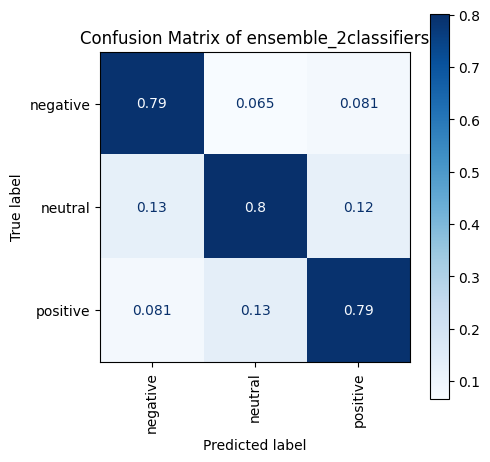

In [57]:
#GRU+LSTM
ensemble_classifer=ensemble_model(AttentionGRU_model,AttentionLSTM_model).to(device,non_blocking=True)
model_name='ensemble_2classifiers'
test_and_report(ensemble_classifer,test_loader,model_name)

Test correct = 597

Test total dataitem = 750

Test Accuracy = 0.7960000038146973

              precision    recall  f1-score   support

    negative       0.78      0.87      0.82       250
     neutral       0.78      0.75      0.76       250
    positive       0.82      0.77      0.80       250

    accuracy                           0.80       750
   macro avg       0.80      0.80      0.80       750
weighted avg       0.80      0.80      0.80       750



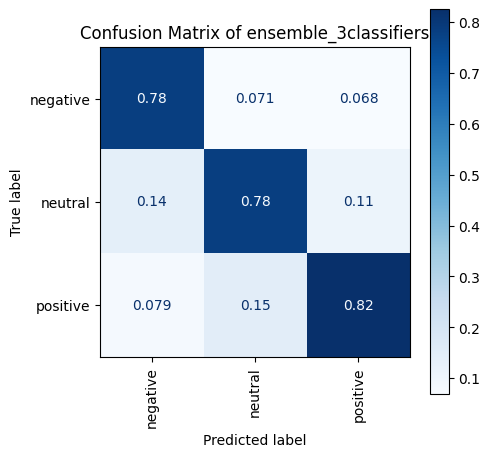

In [50]:
#RNN+GRU+LSTM
ensemble_classifer=ensemble_model(AttentionRNN_model,AttentionGRU_model,AttentionLSTM_model).to(device,non_blocking=True)
model_name='ensemble_3classifiers'
test_and_report(ensemble_classifer,test_loader,model_name)